# Notebook 5: Regression Analysis

To further dive into the effect of demographics (i.e., race/ethnicity, student status) and locale on per-pupil spending, we will perform regression analyses. Please note that, throughout the notebook, we will be interpreting the slopes to be **the change in per-pupil spending for a 1% increase in the demographic variable**.


1. **Initial Heat Map**
     We will first create a heat map to visualize the correlations between the demographic variables and per-pupil spending.

2. **Demographics Regression Analysis**
     - **Bivariate Regression:** We will perform a bivariate OLS linear regression analysis to determine the relationship between each student demographic variable (i.e., race, ethnicity, student status) and per-pupil spending. We will identify the demographic variables with the strongest correlations to per-pupil spending (R-squared) and check for statistical significance $$(p<0.05)$$.
     - **Multiple Regression:** We will then perform a multiple OLS regression analysis [that considers all demographic variables *simultaneously*] to determine how much of the variance in per-pupil spending can be explained by the demographic variables.

3. **Locale Regression Analysis**
     Next, we will perform a **multiple OLS regression analyses** to determine how much of the variance in per-pupil spending can be explained by the demographic variables. We use `smf.ols` for this because the independent variable, `'Locale'`, is categorical data.

4. **Our Combined Model:**
     We create a final model incorporating **only** statistically significant demographic predictors and locale; and revealed that these factors together explain about 12.3% of the variance in per-pupil spending. Interestingly, `English Learner` lost its significance in our final model, suggesting that its earlier significance was partly due to "between-locale" differences and overlap with other demographics.

Overall, the analyses suggest that certain demographics and rural locales are associated with higher per-pupil spending, although the explained variance remains relatively low at 12.3%, suggesting other factors are part of California's LCFF. Further research and analysis will give us a broader picture of what goes into district funding distribution.

## 1.0. Project Dependencies

### 1.1 Import Libraries

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

### 1.2 Import the Cleaned 'district_and_expenses' CSV Data 

In [39]:
# Import and store the cleaned DataFrame from the 'district_and_expenses.csv' file
district_and_expenses = pd.read_csv('district_and_expenses.csv')

# Display the imported 'district_and_expenses' DataFrame
display(district_and_expenses)

,Fed ID,District Code,CDS Code,County Name,District Type,Grade Low,Grade High,Grade Low Census,Grade High Census,Assistance Status,...,Students with Disabilities (%),Socioeconomically Disadvantaged,Socioeconomically Disadvantaged (%),District Label,District Name,EDP 365,Expense ADA,Expense per ADA,LEA Type,Decimal Difference
0,601770.0,61119,1.611190e+12,Alameda,Unified,KG,12,KG,12,General Assistance,...,12.200000,4035.0,38.200000,Alameda Unified (Alameda),Alameda Unified,1.550948e+08,8567.86,18101.93,Unified,0.232163
1,601860.0,61127,1.611270e+12,Alameda,Unified,KG,12,KG,12,General Assistance,...,9.000000,1122.0,31.400000,Albany City Unified (Alameda),Albany City Unified,6.149090e+07,3435.41,17899.14,Unified,0.040342
2,604740.0,61143,1.611430e+12,Alameda,Unified,KG,12,KG,12,General Assistance,...,12.000000,2508.0,27.600000,Berkeley Unified (Alameda),Berkeley Unified,2.205508e+08,8572.17,25728.70,Unified,0.058892
3,607800.0,61150,1.611500e+12,Alameda,Unified,KG,12,KG,12,General Assistance,...,11.000000,3686.0,38.800000,Castro Valley Unified (Alameda),Castro Valley Unified,1.424913e+08,8991.52,15847.30,Unified,0.055328
4,612630.0,61168,1.611680e+12,Alameda,Unified,KG,12,KG,12,General Assistance,...,12.500000,327.0,54.500000,Emery Unified (Alameda),Emery Unified,1.586300e+07,554.70,28597.44,Unified,0.081666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,NaN,76349,NaN,Mendocino,Elementary,KG,12,KG,8,General Assistance,...,14.883721,243.0,56.511628,Arena Union Elementary/Point Arena Joint Union...,Arena Union Elementary/Point Arena Joint Union...,1.016266e+07,325.53,31218.80,Comm Admin,0.320923
928,NaN,40261,NaN,Santa Cruz,Elementary,KG,5,KG,5,General Assistance,...,14.636480,2304.0,36.734694,Santa Cruz City Elementary/High (Santa Cruz),Santa Cruz City Elementary/High,1.152800e+08,5688.18,20266.58,Comm Admin,0.102637
929,NaN,40246,NaN,Sonoma,Elementary,KG,12,KG,6,NaN,...,17.717921,3326.0,45.018950,Petaluma City Elementary/Joint Union High (Son...,Petaluma City Elementary/Joint Union High,1.252075e+08,6651.17,18824.88,Comm Admin,0.110782
930,NaN,40253,NaN,Sonoma,Elementary,KG,8,KG,6,NaN,...,17.340181,7541.0,50.959589,Santa Rosa City Schools (Sonoma),Santa Rosa City Schools,2.486762e+08,11701.14,21252.30,Comm Admin,0.264663


### 1.3 Configuration (Constants)

In [93]:
Y = "Expense per ADA"

DEMOGRAPHIC_COLS = [
    "African American (%)", "American Indian (%)", "Asian (%)", "Filipino (%)",
    "Hispanic (%)", "Pacific Islander (%)", "White (%)", "Two or More Races (%)",
    "Socioeconomically Disadvantaged (%)", "Students with Disabilities (%)",
    "Homeless (%)", "Foster (%)", "Migrant (%)", "English Learner (%)",
]

KEY5_COLS = [
    "Socioeconomically Disadvantaged (%)",
    "Students with Disabilities (%)",
    "Foster (%)",
    "English Learner (%)",
]  # Locale handled via C(Locale)

### 1.4 Helper Function

In [168]:
def run_bivariate(df, x, y, return_model=False):
    """
    Fit y ~ x (bivariate OLS)
    Returns bivariate OLS model and dictionary if return_model=True;
        Else returns only a dictionary with:
            - Slope (Funding per 1% increase)
            - R_squared
            - p-value
    
    Slope is interpreted as $"Expense per ADA" per 1 percentage-point.
    """
    
    predictor_variable = f'Q("{x}")'
    formula = f'Q("{y}") ~ {predictor_variable}'
    model = smf.ols(formula, data=df).fit()

    row = {
        "Variable": x,
        "Slope (Funding per 1% increase)": model.params[predictor_variable],
        "R_squared": model.rsquared,
        "p-value": model.pvalues[predictor_variable],
    }

    if return_model:
        return model, row
    else:
        return row

## 2.0 Demographics Heat Map

This Pearson correlation matrix will help us visualize the relationships between student demographic percentage variables and per-pupil spending.

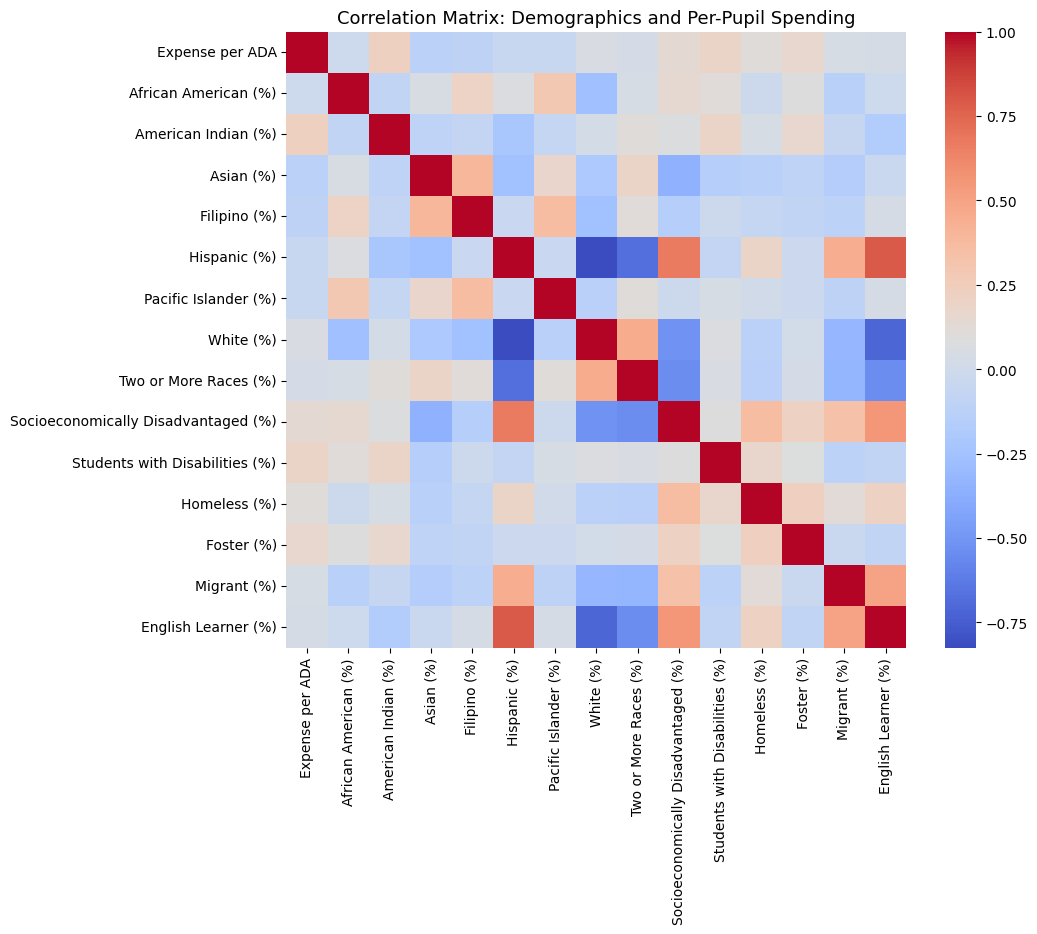

In [48]:
# Demographic & Student Status Columns
cols = [Y] + DEMOGRAPHIC_COLS
corr = district_and_expenses[cols].corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr,
            cmap='coolwarm')
plt.title('Correlation Matrix: Demographics and Per-Pupil Spending', fontsize=13)
plt.show()

The heat map shows us that the strongest correlations between per-pupil spending and a demographic variable are between per-pupil spending and:
- `'American Indian (%)'`
- `'Socioeconomically Disadvantaged (%)'`
- `'Students with Disabilities (%)'`
- `'Foster (%)'`
- `'Homeless (%)'`

However, these correlations remain weak.

Other notable or strong correlations include:
- '`Hispanic (%)'` &:
    - **`'English Learner (%)'` (strong positive)**
    - `'Migrant (%)'` (positive)
    - **`'Socioeconomically Disadvantaged (%)'` (strong positive)**
    - **`'Two or More Races (%)'` (strong negative)**
    - **`'White (%)'` (strong negative)**
- `'White (%)'` &:
    - **`'English Learner (%)'` (strong negative)**
    - `'Migrant (%)'` (negative)
    - **`'Socioeconomically Disadvantaged (%)'` (strong negative)**
    - `'Two or More Races (%)'` (positive)
- `'Two or More Races (%)'` &:
    - `'English Learner (%)'` (negative)
    - `'Migrant (%)'` (negative)
    - `'Socioeconomically Disadvantaged (%)'` (negative)
    - `'White (%)'` (positive)
- `'Socioeconomically Disadvantaged (%)'` &:
    - **`'English Learner (%)'` (strong positive)**
    - `'Migrant (%)'` (positive)
    - `'Homeless (%)'` (positive)
- `'Migrant (%)'` &:
    - **`'English Learner (%)'` (strong positive)**

It is important to note that, while there are strong correlations between some demographic variables, these **correlations do not imply causality**. Analysis of some of these correlations are also outside of our project scope; however, they provide interesting avenues for further research.

## 3.0 Demographics Regression Analysis

We will run univariate linear regression analyses to determine the relationship between each demographic variable and per-pupil spending.

We will also run a multiple regression analysis to determine how much of the variance in per-pupil spending can be explained by the demographic variables.

### 3.1 SED vs. 'Expense per ADA' Column (Bivariate Linear Regression with OLS)

To test the waters, we will first run a simple bivariate linear regression analysis between `'Socioeconomically Disadvantaged (%)'` (SED) and per-pupil spending.

In [156]:
sed_model, sed_row = run_bivariate(district_and_expenses,
                        x="Socioeconomically Disadvantaged (%)",
                        y=Y,
                        return_model=True)

display(sed_row)
print(sed_model.summary())


{'Variable': 'Socioeconomically Disadvantaged (%)',
 'Slope (Funding per 1% increase)': 66.06162023813346,
 'R_squared': 0.020694412665336448,
 'p-value': 1.0395678907548472e-05}

                             OLS Regression Results                             
Dep. Variable:     Q("Expense per ADA")   R-squared:                       0.021
Model:                              OLS   Adj. R-squared:                  0.020
Method:                   Least Squares   F-statistic:                     19.65
Date:                  Thu, 09 Oct 2025   Prob (F-statistic):           1.04e-05
Time:                          01:47:59   Log-Likelihood:                -9994.1
No. Observations:                   932   AIC:                         1.999e+04
Df Residuals:                       930   BIC:                         2.000e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

A bivariate linear regression analysis between SED % and per-pupil spending shows that there is a **weak positive correlation** between the two variables.
- The R-squared value is the measurement of how much of the independent variable (SED %) is explained by changes in our dependent variables (per-pupil spending).
    - In this case, our R-squared value, 0.021, is very low, which indicates that this simple linear model explains very little of the variance in per-pupil spending.
- The F-statistic tells us whether the overall model is statistically significant. A larger F-statistic indicates a more statistically significant model.
    - In this case, our F-statistic, 19.65, is greater than 1, which indicates that the overall model is statistically significant.
- The slope, 66.0616, indicates that there is approximately a $66.06 increase in `'Expense per ADA'` for every 1% increase in SED student %.
- The *p*-value, $$0.000 < 0.05$$, indicates that the relationship between SED % and per-pupil spending is statistically significant.

### 3.2 Demographics vs. Expense per ADA Column (OLS Regression)

With a successful first run, we will now run linear regression analyses between **each** demographic variable and per-pupil spending. We will extract the values from each summary (similar to the one generated above) and put it into a table. The values we are interested in are the slope (funding per 1% increase of a demographic), R-squared, and *p*-value.

We will then sort the results by R-squared value to identify the demographic variable with the strongest correlation to per-pupil spending.

In [162]:
rows = []
for col in DEMOGRAPHIC_COLS:
    row = run_bivariate(district_and_expenses, x=col, y=Y)
    rows.append(row)

reg_summary_3_2 = (
    pd.DataFrame(rows)
      .sort_values("R_squared", ascending=False)
)

display(reg_summary_3_2)

,Variable,Slope (Funding per 1% increase),R_squared,p-value
1,American Indian (%),363.038118,0.050119,4.735698e-12
9,Students with Disabilities (%),467.717097,0.035582,6.509304e-09
11,Foster (%),1417.501283,0.026663,5.386721e-07
8,Socioeconomically Disadvantaged (%),66.061620,0.020694,1.039568e-05
2,Asian (%),-122.950513,0.014335,2.488163e-04
3,Filipino (%),-509.360260,0.011738,9.236463e-04
10,Homeless (%),231.948033,0.011400,1.096424e-03
6,White (%),25.330325,0.003222,8.327367e-02
4,Hispanic (%),-21.356998,0.002920,9.919650e-02
5,Pacific Islander (%),-1167.023190,0.002848,1.035043e-01


This table shows us that the demographic variable with the strongest correlation to per-pupil spending is **`'American Indian (%)'`**, with a slope of 102.56 and an R-squared value of 0.05. The *p*-value, $$0.000 < 0.05$$, also indicates that this relationship is statistically significant. This means that there is approximately a $102.56 increase in `'Expense per ADA'` for every 1% increase in students who identify as American Indian.

There are 3 **statistically insignificant** (*p* > 0.05) relationships between demographic variables and per-pupil spending:
- `'White (%)'`
- `'Hispanic (%)'`
- `'Pacific Islander (%)'`

#### 3.2.1 Multiple Regression Analysis (OLS)

The previous regression analysis calculated correlations between each demographic variable and per-pupil spending. However, these analyses do not account for the relationships **between** demographic variables (e.g., joint effects, multicollinearity).

Thus, we ran a multiple regression analysis that simultaneously included all student demographics. This analysis will tell us how much of the variance in per-pupil spending can be explained by demographics.

In [165]:
X = district_and_expenses[DEMOGRAPHIC_COLS]
X = sm.add_constant(X)
y = district_and_expenses[Y]

model_multi_3_2_1 = sm.OLS(y, X).fit()

print(model_multi_3_2_1.summary())

                            OLS Regression Results                            
Dep. Variable:        Expense per ADA   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     10.39
Date:                Thu, 09 Oct 2025   Prob (F-statistic):           4.78e-22
Time:                        01:50:33   Log-Likelihood:                -9935.3
No. Observations:                 932   AIC:                         1.990e+04
Df Residuals:                     917   BIC:                         1.997e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

This summary table shows us that the multiple regression model explains about 13.7% of the variance in per-pupil spending.

Significant **positive predictors** of per-pupil spending included:
- `'Socioeconomically Disadvantaged (%)'` ($74.02 per 1% increase)
- `'Students with Disabilities (%)'` ($325.62)
- `'Foster (%)'` ($832.43)
- `'English Learner (%)'` ($195.40)

There were no significant negative student status predictors. There were no significant demographic variables that were positive or negative predictors.

## 4.0 'Locale' Regression Analysis (Categorical)

Our project also seeks to determine whether the locale of a district affects per-pupil spending.

### 4.1 'Expense per ADA' by 'Locale' Columns

Unlike % demographics and `'Expense ADA'`, which were both quantitative variables, Locale is a categorical variable. Thus, we will use a **categorical regression analysis** in `smf` to determine the relationship between `'Locale'` and `'Expense per ADA'`.

In [81]:
model_4_1 = smf.ols('Q(Y) ~ C(Locale)', data=district_and_expenses).fit()

print(model_4_1.summary())

                            OLS Regression Results                            
Dep. Variable:                   Q(Y)   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     13.03
Date:                Thu, 09 Oct 2025   Prob (F-statistic):           2.51e-10
Time:                        01:16:30   Log-Likelihood:                -9978.4
No. Observations:                 932   AIC:                         1.997e+04
Df Residuals:                     927   BIC:                         1.999e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

We did not stipulate which district to use as our "baseline" district. However, the `smf.ols` function automatically uses the first district in the dataset as the baseline district. In this case, the first district is **`'Urban'`**. Thus, all interpretations of coefficients should be interpreted as relative to `'Urban'` districts.

Our multiple regression analysis shows that the locale of a district does not significantly affect per-pupil spending (R-squared = 0.053).

Of the four locales, we found only `'Rural'` to have a statistically significant relationship with per-pupil spending. `'Rural'` districts have approximately **$5,347 more** in per-pupil spending than `'Urban'` districts.

### 4.2 'Locale' Columns & Demographics

With our OLS analyses above, we were able to determine the following statistically significant demographics:
- `'Socioeconomically Disadvantaged (%)'`
- `'Students with Disabilities (%)'`
- `'Foster (%)'`
- `'English Learner (%)'`
- `'Rural'` (`'Locale'`)

Thus, we will run a multiple regression analysis on our final, 5-variable model that includes all of the above variables to determine how much of the variance in per-pupil spending can be explained by them.

In [96]:
final_model_formula = 'Q(Y) ~ C(Locale)'

for col in KEY5_COLS:
    final_model_formula += f' + Q("{col}")'

final_model_dem_locale = smf.ols(final_model_formula, data=district_and_expenses).fit()

print(final_model_dem_locale.summary())

                            OLS Regression Results                            
Dep. Variable:                   Q(Y)   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     16.21
Date:                Thu, 09 Oct 2025   Prob (F-statistic):           1.47e-22
Time:                        01:21:24   Log-Likelihood:                -9942.6
No. Observations:                 932   AIC:                         1.990e+04
Df Residuals:                     923   BIC:                         1.995e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

From our multiple OLS regression analysis, we found that the 5-variable model explains about 12.3% of the variance in per-pupil spending.

Statistically significant **positive predictors** of per-pupil spending included:
- `'Socioeconomically Disadvantaged (%)'` ($33.79 per 1% increase)
- `'Students with Disabilities (%)'` ($463.75)
- `'Foster (%)'` ($1101.28)
- `'English Learner (%)'` ($37.41)
- `'Rural'` ($5211.48 more than `'Urban'`)

One change that we observed is that `'English Learner (%)'` became a statistically insignificant predictor of per-pupil spending.

#### So why did `'English Learner (%)'` lose significance in our 5-variable model?

In our bivariate and demographics-only multiple regressions, `'English Learner (%)'` (EL) appeared significant with a *p*-value of ~0.000. However, when we added `C(Locale)` (and retained `'Socioeconomically Disadvantaged (%)'`, `'Students with Disabilities (%)'`, `'Foster (%)'`), EL's changed to being statistically insignificant.

This indicates that part of EL's earlier values reflected between-locale differences and overlapped with other demographics. After controlling for locale and our key demographic covariates, EL's unique, partial effect on per-pupil spending dimished and became statistically insignificant.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=246b06f0-3e45-45e3-acef-efea2bae7701' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>